## Gene-CRE linking analysis
**Note:** Portions of the code were adapted from the [Signac vignettes](https://stuartlab.org/signac/articles/overview).

In [1]:

# Install required packages if not already installed
if (!requireNamespace("Seurat", quietly = TRUE)) {
    install.packages("Seurat")
}

if (!requireNamespace("Signac", quietly = TRUE)) {
    install.packages("Signac")
}

if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
}

if (!requireNamespace("GenomicRanges", quietly = TRUE)) {
    BiocManager::install("GenomicRanges")
}

if (!requireNamespace("BSgenome.Hsapiens.UCSC.hg38", quietly = TRUE)) {
    BiocManager::install("BSgenome.Hsapiens.UCSC.hg38")
}

if (!requireNamespace("dplyr", quietly = TRUE)) {
    install.packages("dplyr")
}

if (!requireNamespace("ggplot2", quietly = TRUE)) {
    install.packages("ggplot2")
}

if (!requireNamespace("ggforce", quietly = TRUE)) {
    install.packages('ggforce')
}

if (!requireNamespace("patchwork", quietly = TRUE)) {
    install.packages("patchwork")
}

if (!requireNamespace("ggnewscale", quietly = TRUE)) {
    install.packages("ggnewscale")
}

if (!requireNamespace("viridisLite", quietly = TRUE)) {
    install.packages("viridisLite")
}

suppressPackageStartupMessages({
    suppressWarnings({
        library(Seurat)
        library(Signac)
        library(GenomicRanges)
        library(BSgenome.Hsapiens.UCSC.hg38)
        
        library(dplyr)
        
        library(ggplot2)
        library(ggforce)
        library(patchwork)
        library(ggnewscale)
        library(viridisLite)
    })
})



### 1. What are CREs and gene-CRE links?

***cis*-regulatory elements** (CREs) are specific DNA sequences that influence transcription of the gene, locating on the same chromosome as the gene they regulate.

We are interested in **linking CREs to their target genes**.


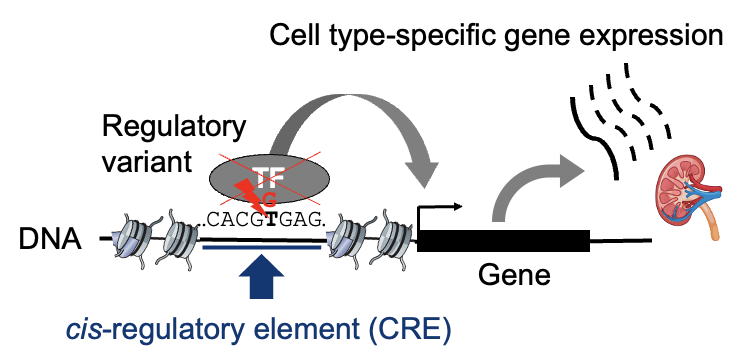

### 2. Gene-enhancer linking methods

All current methods to link enhancers to their target genes are correlation-based relying on the hypothesis that:

- An open enhancer means it is binding to the transcription factor to increase transcription of the gene, therefore we should observe more gene expression
- A closed enhancer means it is not binding to the transcription factor, threfore we should observe less gene expression
- Expression of a gene which is not a target of the enhancer should not correlate with the chromatin accessibility


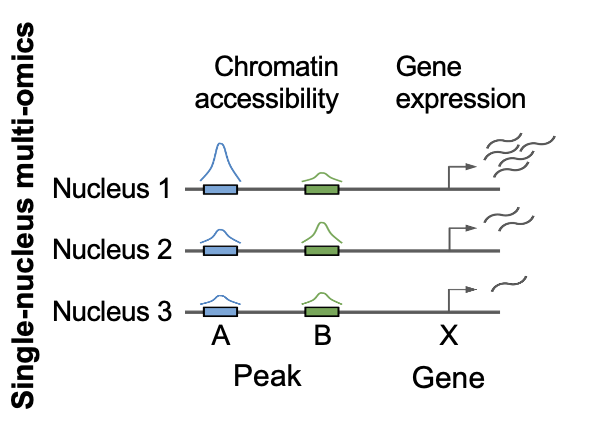

In the example above:
- When peak A is more open, gene X is expressed more, and vice versa.
- The accessibility of peak B does not correlate with expression of gene X.

In other words, there is an **association** (not causation) between peak A and gene X.

To make sure that peak A is the *cis*-regulatory elements influencing gene X, we need more direct evidence.

For all below analysis, we will use `LinkPeaks()` function from the `Signac` package to link peaks and genes from two modalities.


##### Load the joint RNA-seq/ATAC-seq Seurat object

In [2]:
# multi_merged <- readRDS("../data/PBMC.joint.rds")
multi_merged <- readRDS("PBMC.joint.rds")
multi_merged

An object of class Seurat 
418325 features across 17214 samples within 3 assays 
Active assay: SCT (24383 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: RNA, ATAC
 6 dimensional reductions calculated: pca, harmony_rna, umap, atac.integrated_lsi, atac.umap, wnn.umap

##### Set the annotated cell type as Idents of the Seurat

In [3]:
Idents(multi_merged) <- multi_merged@meta.data$annot_cell_type

##### Compute the GC content for each peak for later bias correction. 
##### Note that in this step you need to load hg38 genome

In [4]:
DefaultAssay(multi_merged) <- "ATAC"
multi_merged <- RegionStats(multi_merged, genome = BSgenome.Hsapiens.UCSC.hg38)

Warning message in RegionStats.default(object = regions, genome = genome, verbose = verbose, :
“Not all seqlevels present in supplied genome”


##### Run Signac
`LinkPeaks()` function finds correlation between gene expression and chromatin accessibility. 

Arguments:
- `expression.assay`: name of RNA-seq assay
- `expression.slot`: name of RNA-seq layer (either raw `counts` or normalized `data`)
- `peak.assay`: name of ATAC-seq assay
- `peak.slot`: name of ATAC-seq layer (either raw `counts` or normalized `data`)
- `distance`: maximum distance (in bp) between center of peaks and gene TSS to be considered for linking
- `genes.use`: list of genes to test
- `n_sample`: number of peaks to sample at random when computing the null distribution and estimating p-value
- `pvalue_cutoff`: minimum p-value required to retain a link. Links with a p-value equal or greater than this value will be removed from the output.
- `score_cutoff`: minimum absolute value of correlation coefficient for a link to be retained

*Note*: We usually correlate **normalized** RNA-seq data and **raw/binarized** ATAC-seq data.



In [5]:

# link peaks to genes
multi_merged <- LinkPeaks(
    object = multi_merged,
    expression.assay = "SCT", expression.slot = "data",
    peak.assay = "ATAC", peak.slot = "counts",
    distance = 500000,
    genes.use = c("LYZ"),   # marker gene for monocytes
    n_sample = 200,
    pvalue_cutoff = 1, # cutoff for p-value
    score_cutoff = 0   # cutoff for correlation
)


Testing 1 genes and 130225 peaks

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': GL000194.1, GL000195.1, GL000205.2, GL000218.1, GL000219.1, KI270711.1, KI270713.1, KI270721.1, KI270726.1, KI270727.1, KI270728.1, KI270734.1
  - in 'y': chrMT
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”


##### The output was stored in Links layer of the Seurat object

In [6]:
Links(multi_merged)

GRanges object with 62 ranges and 5 metadata columns:
       seqnames            ranges strand |       score        gene
          <Rle>         <IRanges>  <Rle> |   <numeric> <character>
   [1]    chr12 68864068-69348341      * |  0.05221054         LYZ
   [2]    chr12 68868039-69348341      * |  0.02941458         LYZ
   [3]    chr12 68872201-69348341      * |  0.06022890         LYZ
   [4]    chr12 68889878-69348341      * |  0.00255476         LYZ
   [5]    chr12 68897420-69348341      * |  0.06056212         LYZ
   ...      ...               ...    ... .         ...         ...
  [58]    chr12 69348341-69616192      * |  0.07207241         LYZ
  [59]    chr12 69348341-69639566      * | -0.00394433         LYZ
  [60]    chr12 69348341-69689272      * |  0.07856931         LYZ
  [61]    chr12 69348341-69738814      * | -0.16565778         LYZ
  [62]    chr12 69348341-69739940      * | -0.07138799         LYZ
                         peak     zscore    pvalue
                  <chara

In [7]:
# convert Links to a dataframe

p2g <- as.data.frame(Links(multi_merged))
p2g |> head()

nrow(p2g)


,seqnames,start,end,width,strand,score,gene,peak,zscore,pvalue
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,chr12,68864068,69348341,484274,*,0.05221054,LYZ,chr12-68863628-68864508,-0.09795370,0.4609845
2,chr12,68868039,69348341,480303,*,0.02941458,LYZ,chr12-68867610-68868467,-0.04696181,0.4812718
3,chr12,68872201,69348341,476141,*,0.06022890,LYZ,chr12-68871754-68872648,0.09632901,0.4616296
4,chr12,68889878,69348341,458464,*,0.00255476,LYZ,chr12-68889435-68890321,-0.45238293,0.3254966
5,chr12,68897420,69348341,450922,*,0.06056212,LYZ,chr12-68896994-68897845,0.13139316,0.4477321
6,chr12,68904749,69348341,443593,*,0.04567219,LYZ,chr12-68904278-68905220,-0.11243501,0.4552392


[1] 62

##### The above dataframe contains statistics of linking `LYZ` gene to 62 nearby open chromatin peaks.

Columns:
- `gene`: gene name
- `peak`: peak name
- `score`: correlation
- `zscore`: z-score of correlation for computing p-value
- `pvalue`: p-value


##### Next, we visualize peak-gene links using `CoveragePlot()` function.

Arguments:

- `region`: genome region to plot
- `extend.upstream`: extend upstream in bp
- `extend.downstream`: extend downstream in bp 
- `features`: list of genes for expression plot (if not specified, run on all genes)
- `annotation`: set to TRUE to display the gene diagram
- `peaks`: set top TRUE to display the peaks
- `links`: set to TRUE to display peak-gene links
- `tile`: set to TRUE to display the tile plot


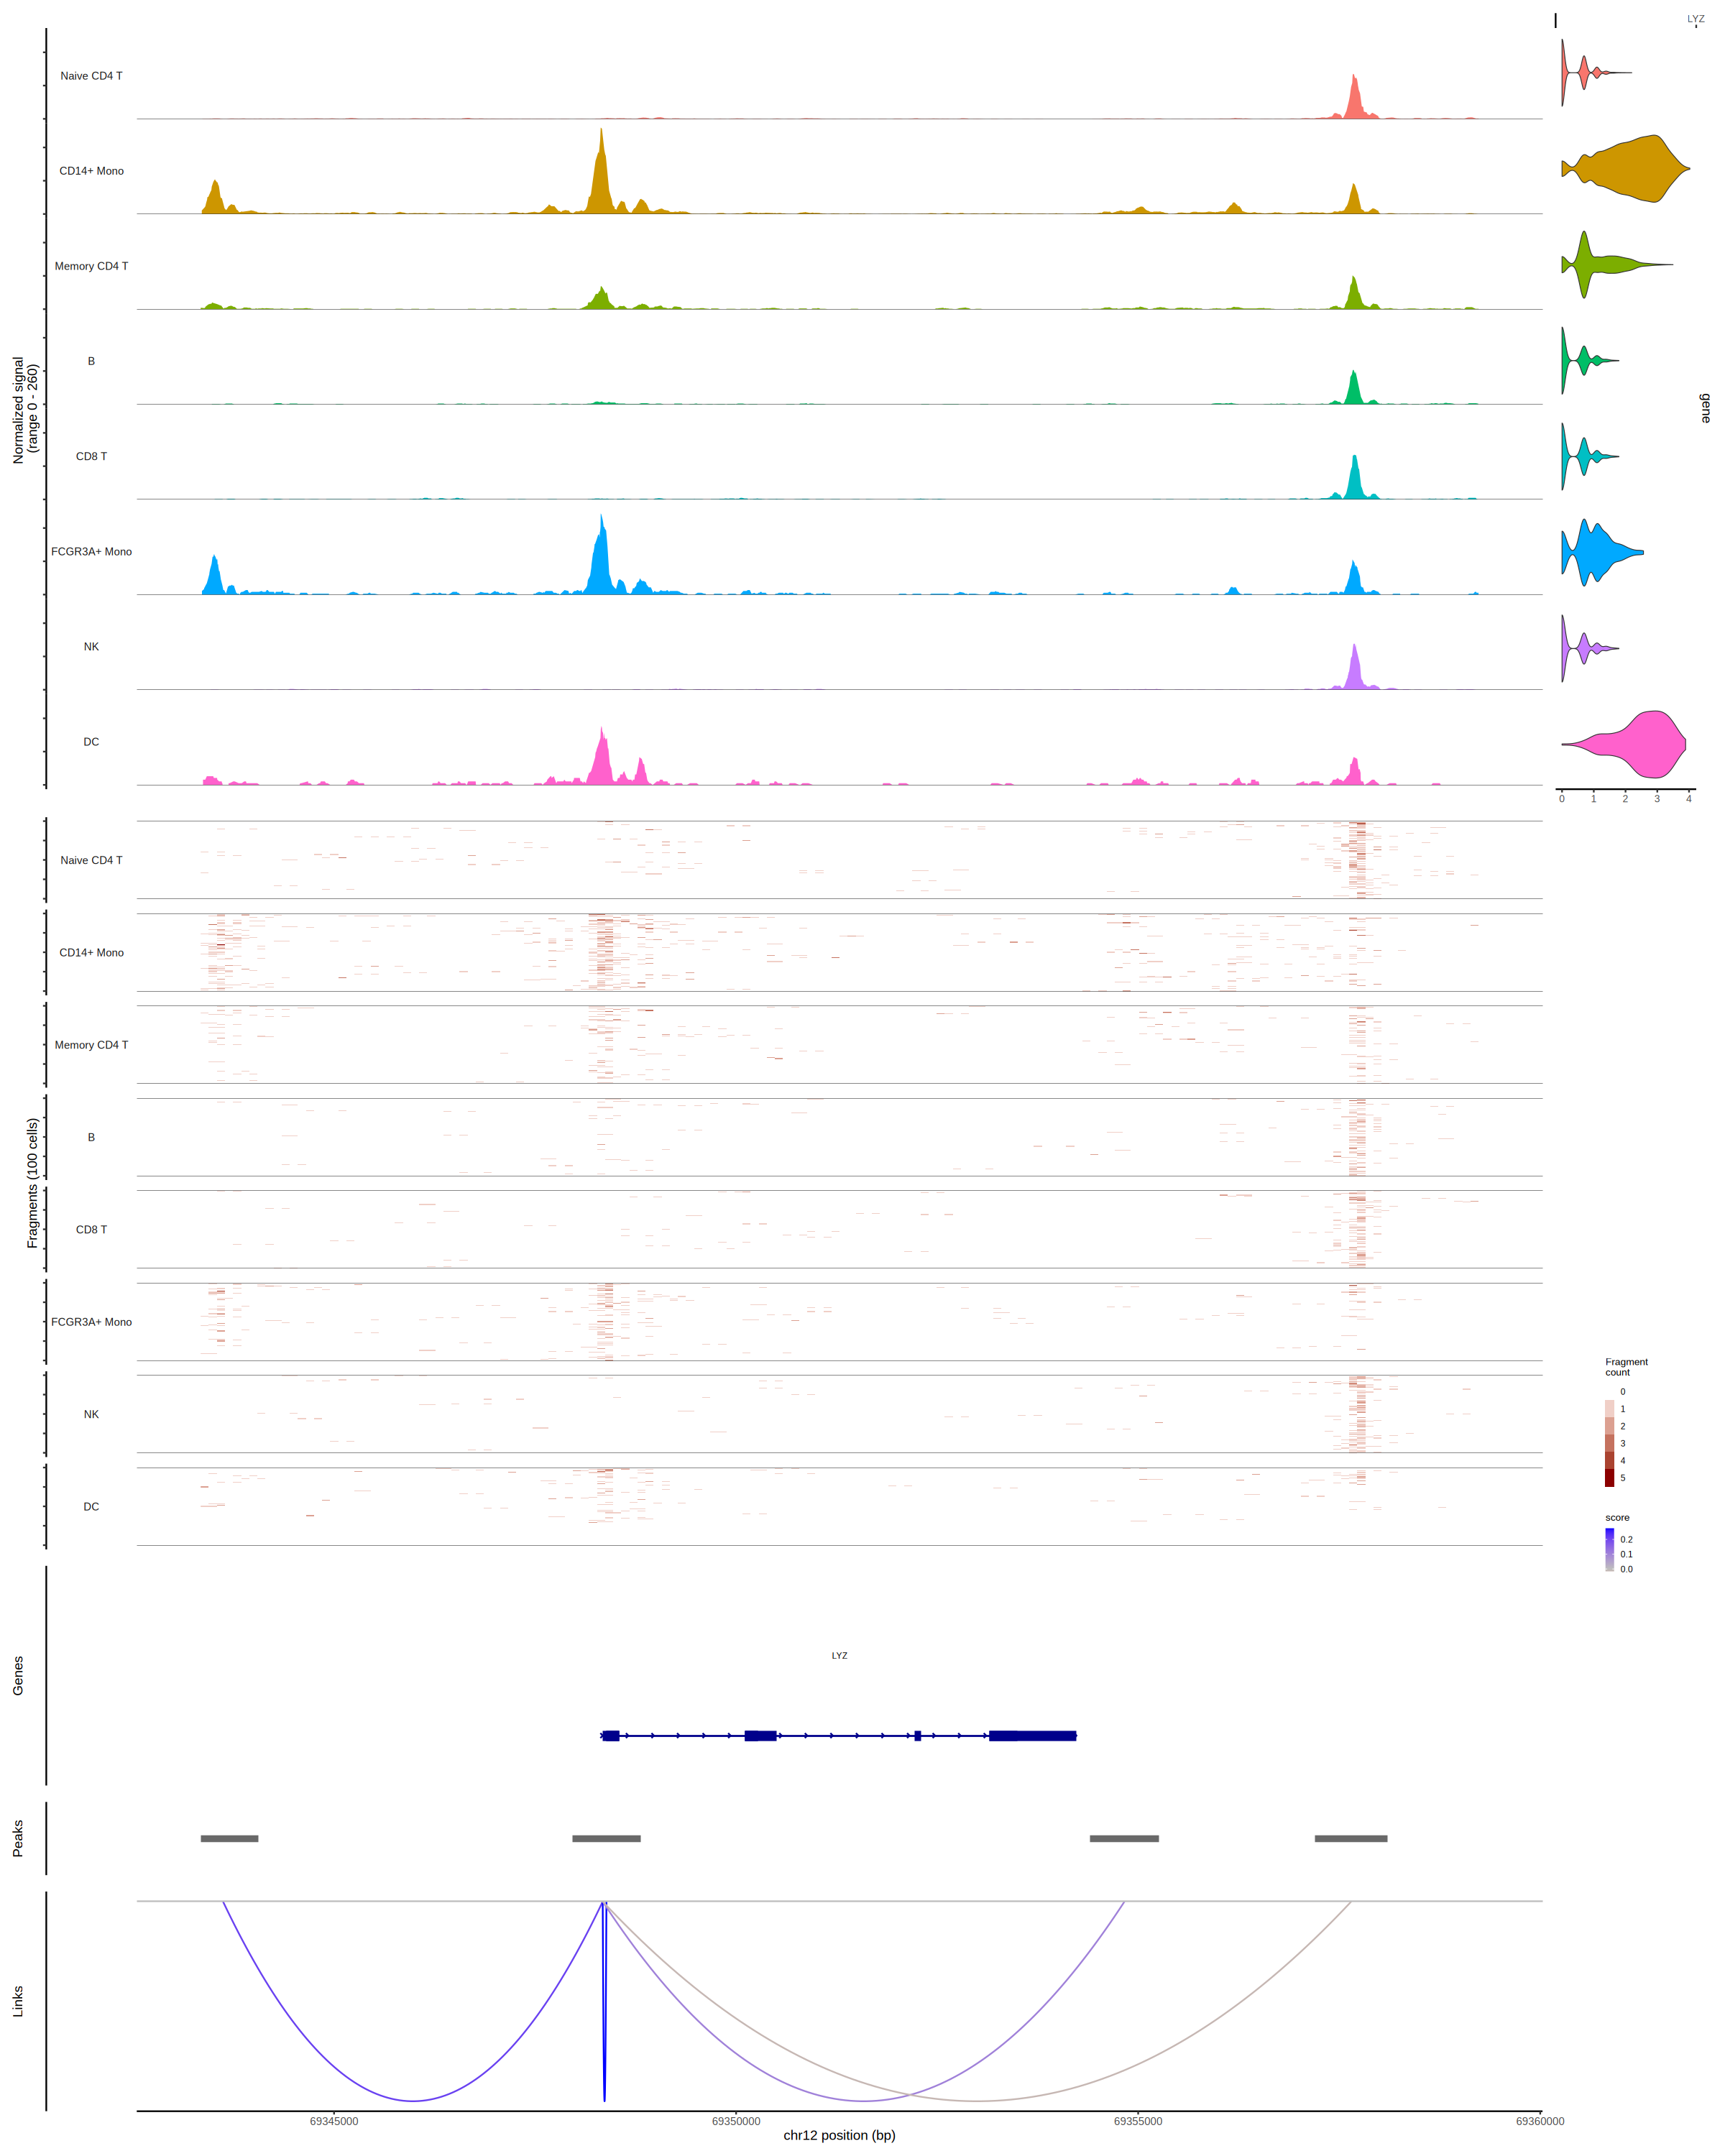

In [8]:

options(repr.plot.width = 20, repr.plot.height = 25)

CoveragePlot(
    object = multi_merged,
    region = "LYZ",
    extend.upstream = 5000,
    extend.downstream = 5000,
    features = c("LYZ"),
    expression.assay = "SCT",
    annotation = TRUE,
    peaks = TRUE,
    links = TRUE,
    tile = TRUE
) #& theme(text = element_text(size = 20))



#### *Note*:
The `CoveragePlot()` function requires the fragment files (`.tsv.gz`) and fragment index files (`.tsv.gz.tbi`).

If you have an error, check the path to these fragment files saved in the `Fragment` slot of the ATAC assay.
Make sure that it is poiniting to the correct files and correct folders (the index file should be in the same folder as its fragment file).

```
sapply(multi_merged[["ATAC"]]@fragments, function(x) x@path)
```

You can manually modify the path to the fragment file as below.

```
multi_merged[["ATAC"]]@fragments[[1]]@path <- "pbmc_unsorted_10k_atac_fragments.tsv.gz"
multi_merged[["ATAC"]]@fragments[[2]]@path <- "10k_PBMC_Multiome_nextgem_Chromium_Controller_atac_fragments.tsv.gz"
multi_merged[["ATAC"]]@fragments[[3]]@path <- "pbmc_unsorted_10k_atac_fragments.tsv.gz"
multi_merged[["ATAC"]]@fragments[[4]]@path <- "10k_PBMC_Multiome_nextgem_Chromium_Controller_atac_fragments.tsv.gz"
```

##### We can also hightlight regions of interest in the CoveragePlot.

##### First, define regions of interests and convert it to a GRanges object.

In [9]:

# Example list of peaks
peak_list <- c("chr12-69343181-69344057", "chr12-69347961-69348813", "chr12-69354403-69355257", "chr12-69357198-69358101")

# Split and convert
peak_parts <- do.call(rbind, strsplit(peak_list, "-"))
gr_peak <- GRanges(
  seqnames = peak_parts[,1],
  ranges = IRanges(start = as.numeric(peak_parts[,2]),
                   end   = as.numeric(peak_parts[,3]))
)

gr_peak


GRanges object with 4 ranges and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]    chr12 69343181-69344057      *
  [2]    chr12 69347961-69348813      *
  [3]    chr12 69354403-69355257      *
  [4]    chr12 69357198-69358101      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

##### Specify the regions to hightlight using `region.highlight` argument in `CoveragePlot()` function.

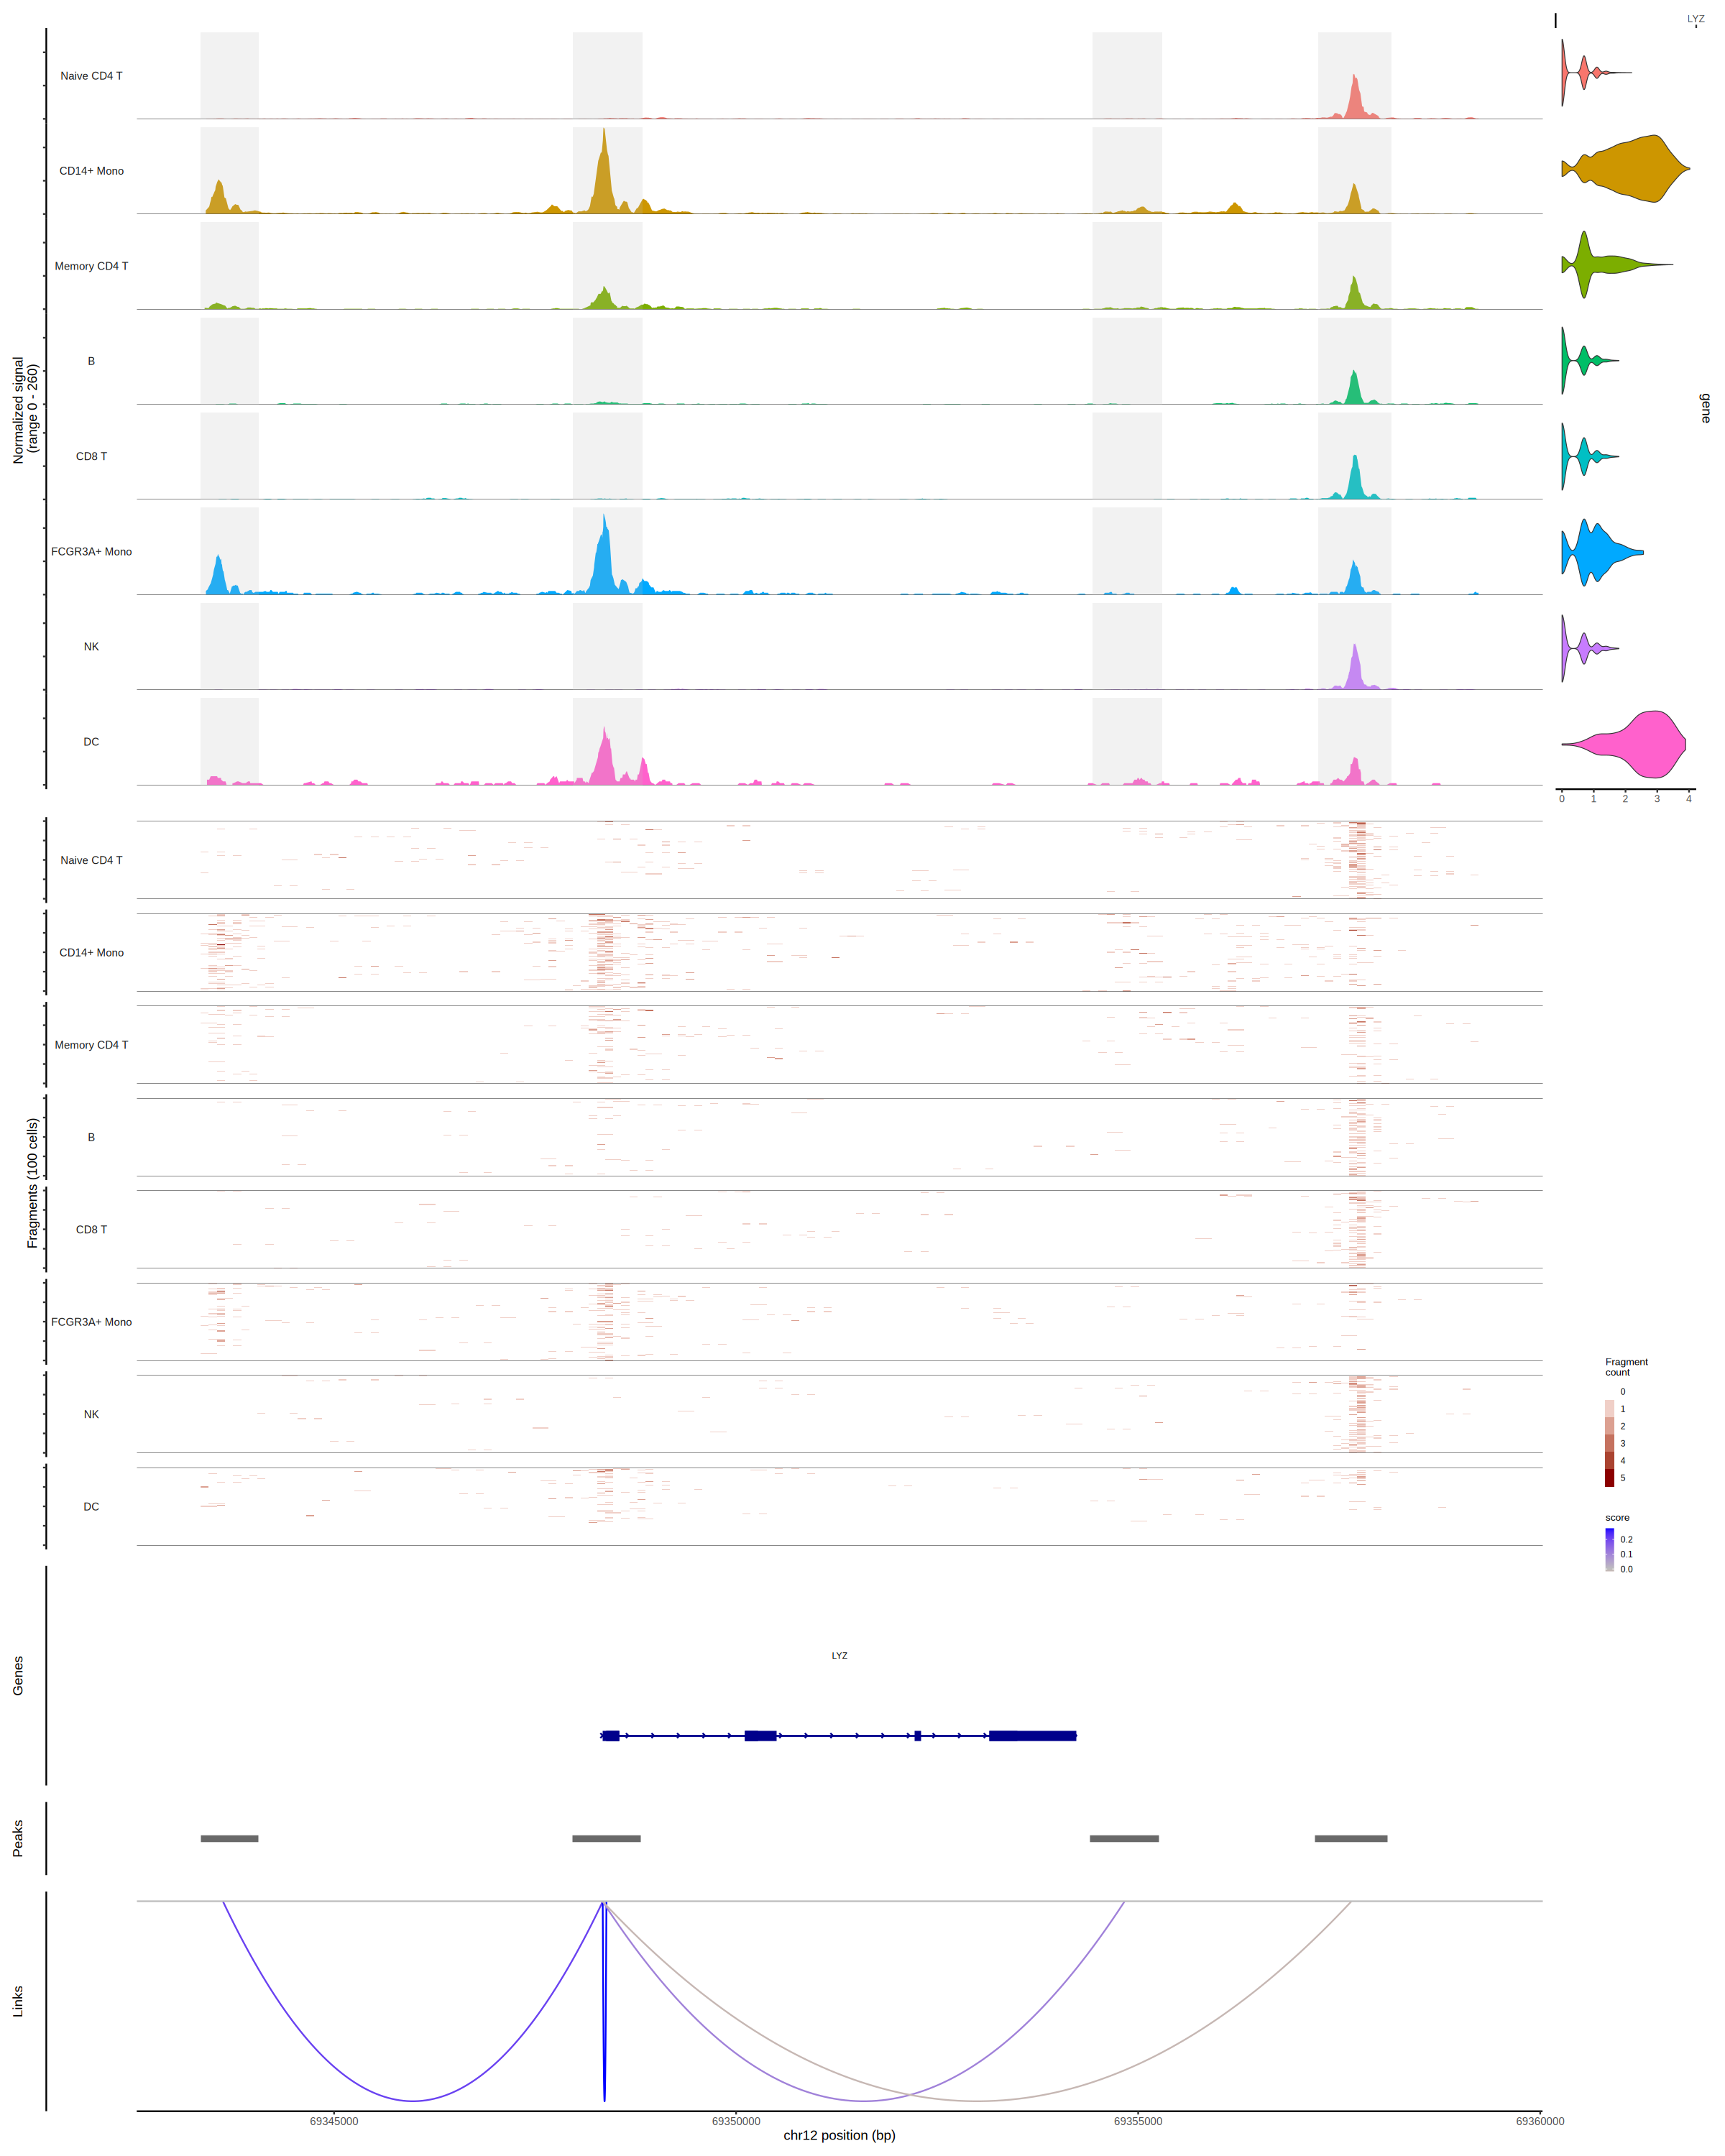

In [10]:

options(repr.plot.width = 20, repr.plot.height = 25)

CoveragePlot(
    object = multi_merged,
    region = "LYZ",
    extend.upstream = 5000,
    extend.downstream = 5000,
    features = c("LYZ"),
    expression.assay = "SCT",
    annotation = TRUE,
    peaks = TRUE,
    links = TRUE,
    tile = TRUE,
    region.highlight = gr_peak
) #& theme(text = element_text(size = 20))



##### We can also run peak-gene linking methods for each cell type.

##### For example, we run Signac for `LYZ` gene on CD14+ monocytes only.


In [11]:
cd14_mono <- subset(multi_merged, idents = "CD14+ Mono")
cd14_mono

An object of class Seurat 
418325 features across 3997 samples within 3 assays 
Active assay: ATAC (130381 features, 0 variable features)
 2 layers present: counts, data
 2 other assays present: RNA, SCT
 6 dimensional reductions calculated: pca, harmony_rna, umap, atac.integrated_lsi, atac.umap, wnn.umap

In [12]:

cd14_mono <- LinkPeaks(
    object = cd14_mono,
    expression.assay = "SCT", expression.slot = "data",
    peak.assay = "ATAC", peak.slot = "counts",
    distance = 500000,
    genes.use = c("LYZ"),
    n_sample = 200,
    pvalue_cutoff = 1,
    score_cutoff = 0
)



Testing 1 genes and 120107 peaks

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': GL000194.1, GL000195.1, GL000205.2, GL000218.1, GL000219.1, KI270711.1, KI270713.1, KI270721.1, KI270726.1, KI270727.1, KI270728.1, KI270734.1
  - in 'y': chrMT
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”


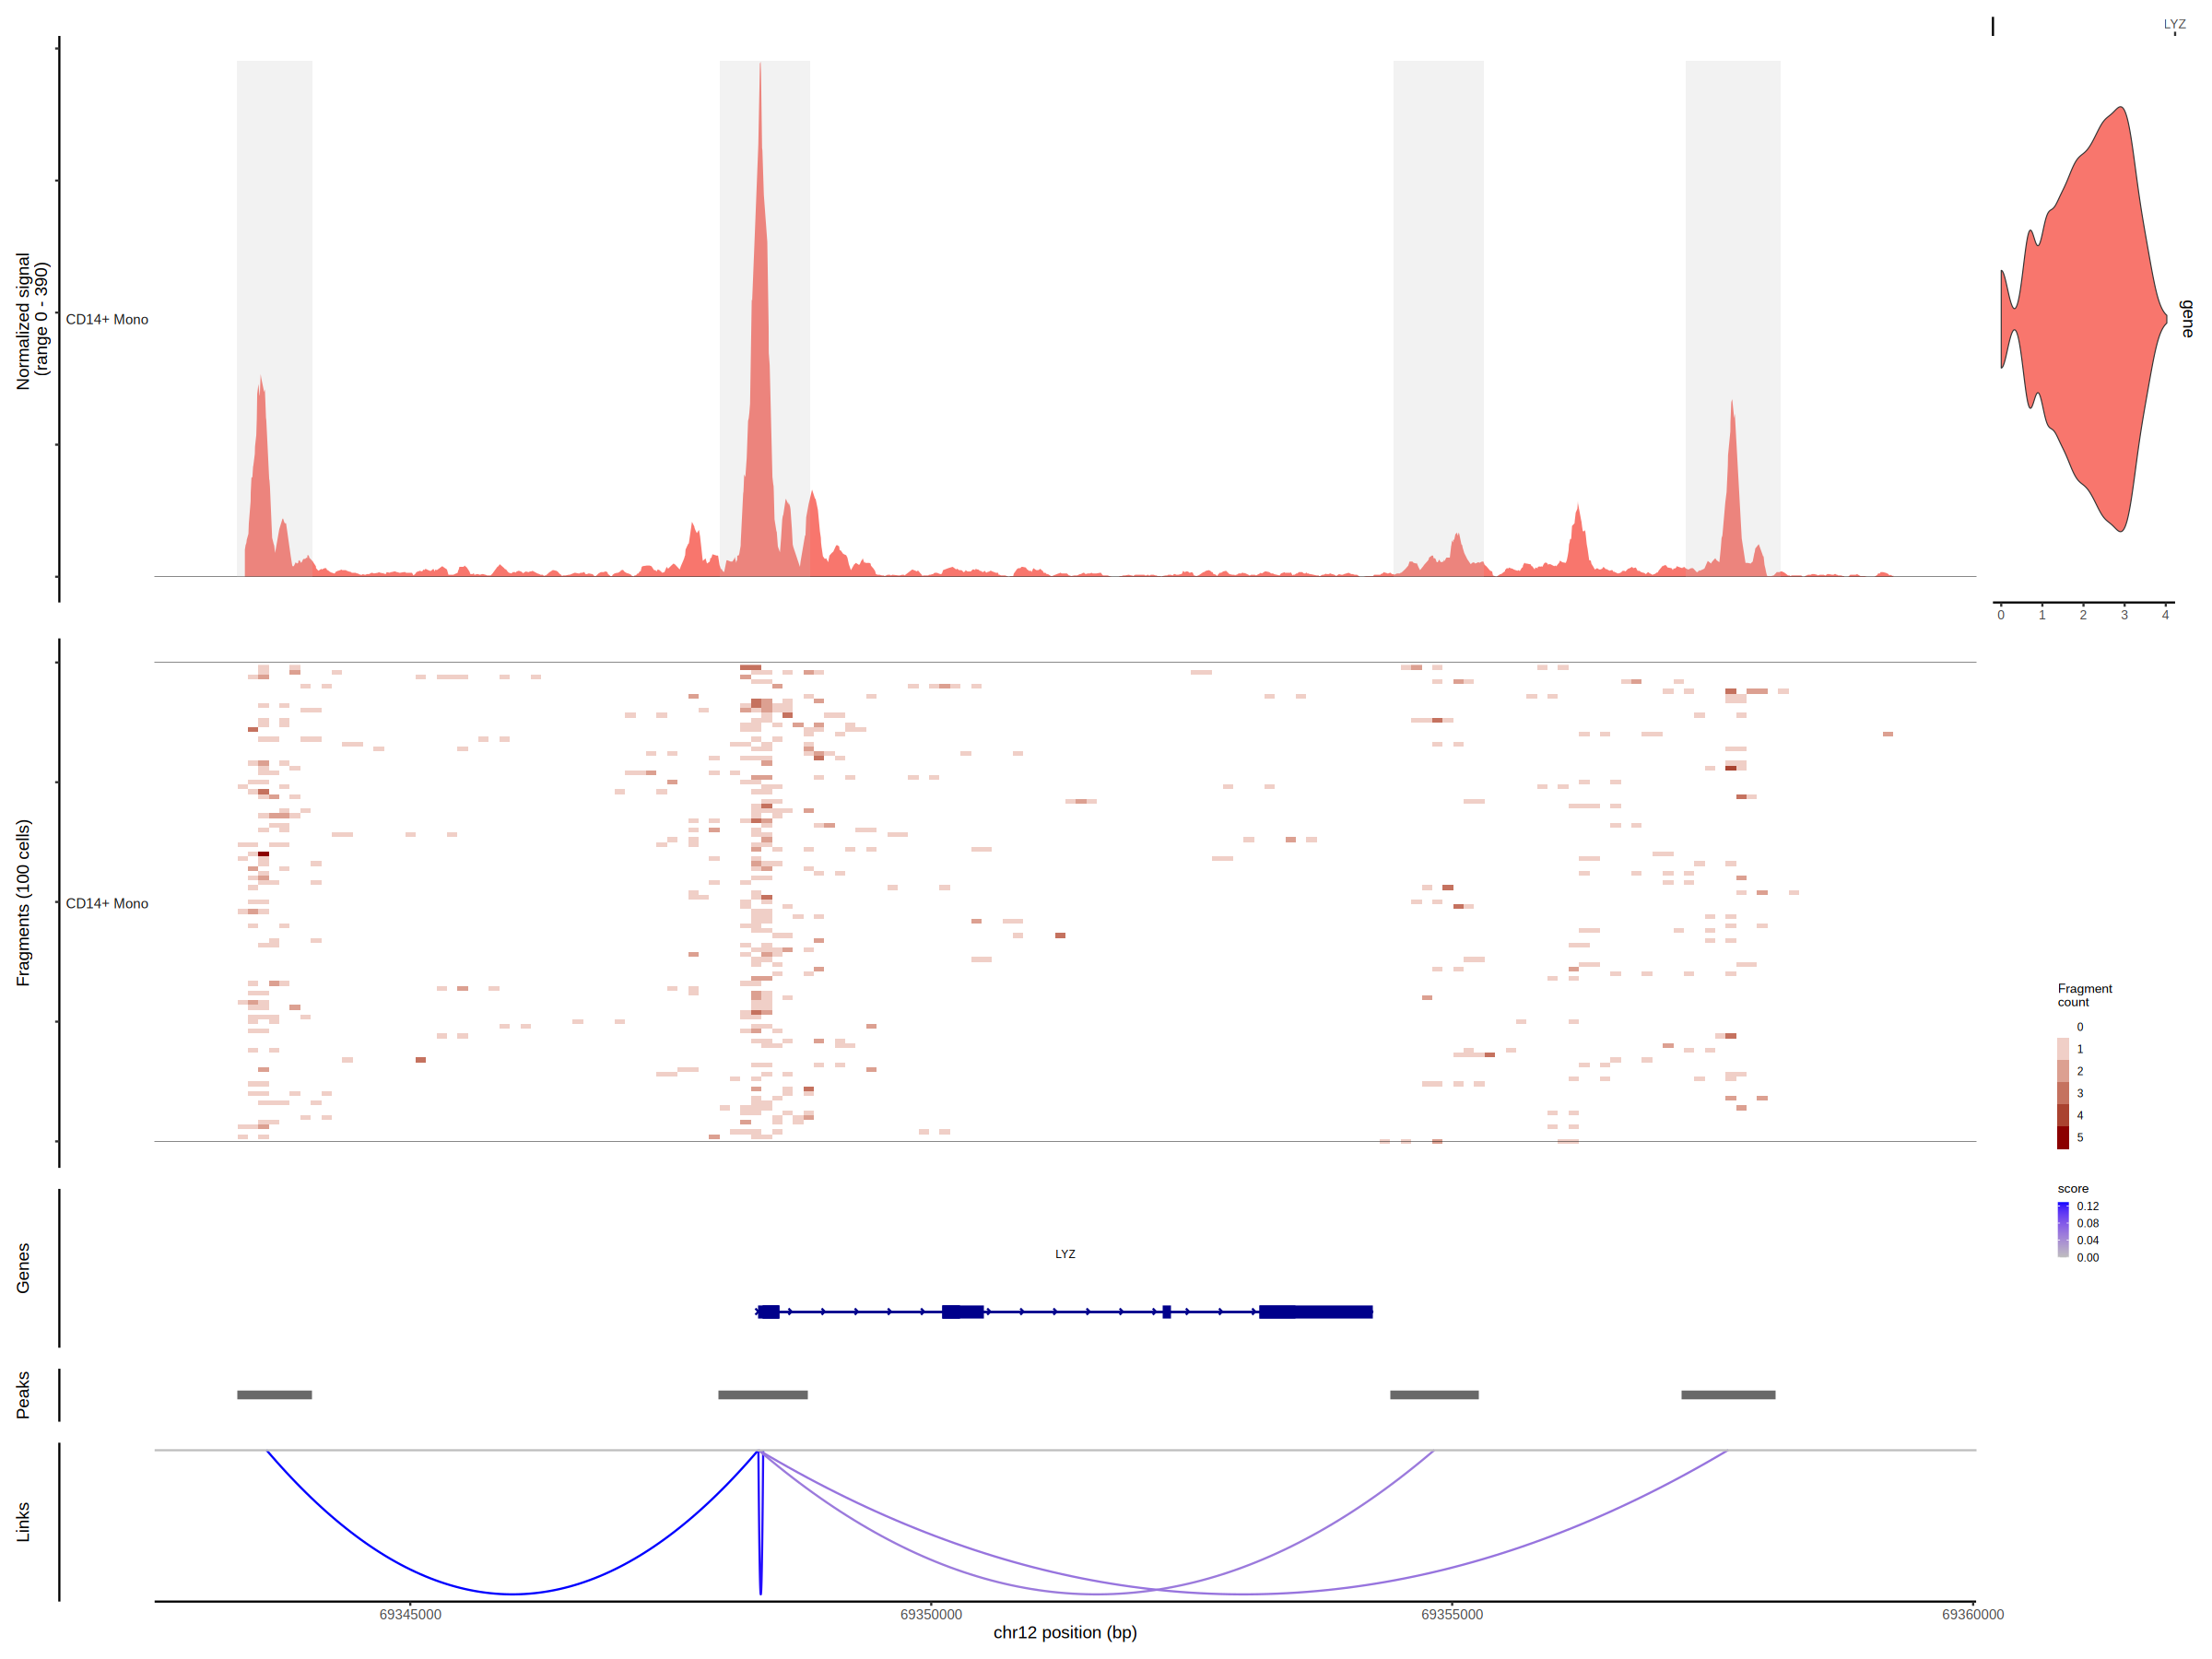

In [13]:

options(repr.plot.width = 20, repr.plot.height = 15)

CoveragePlot(
    object = cd14_mono,
    region = "LYZ",
    features = c("LYZ"),
    expression.assay = "SCT",
    annotation = TRUE,
    peaks = TRUE,
    links = TRUE,
    tile = TRUE,
    region.highlight = gr_peak,
    extend.upstream = 5000,
    extend.downstream = 5000
) #& theme(text = element_text(size = 20))



### 3. Validation of gene-enhancer links

##### Load precomputed Signac results. We ran on all genes and peaks on CD14+ Monocytes with maximal distance of 100kb.

In [14]:

# cd14_mono_obj <- readRDS("../data/cd14_mono_100kb_p2g.rds")
cd14_mono_obj <- readRDS("cd14_mono_100kb_p2g.rds")
cd14_mono_p2g <- as.data.frame(Links(cd14_mono_obj))

cd14_mono_p2g |> head()


,seqnames,start,end,width,strand,score,gene,peak,zscore,pvalue
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,chr1,860470,959309,98840,*,0.0050443504,NOC2L,chr1-860073-860867,0.4270087,0.3346865042
2,chr1,860470,960584,100115,*,-0.0060042088,KLHL17,chr1-860073-860867,-0.4411653,0.3295466577
3,chr1,865857,959309,93453,*,-0.0079911220,NOC2L,chr1-865418-866295,-0.3733688,0.3544370000
4,chr1,865857,960584,94728,*,0.0596219774,KLHL17,chr1-865418-866295,3.5634803,0.0001829851
5,chr1,869923,959309,89387,*,-0.0003919967,NOC2L,chr1-869471-870374,0.1311730,0.4478192348
6,chr1,869923,960584,90662,*,-0.0165374850,KLHL17,chr1-869471-870374,-1.3034197,0.0962157516


In [15]:
cat(paste0("# p2g: ", nrow(cd14_mono_p2g), "\n"))
cat(paste0("# gene: ", length(unique(cd14_mono_p2g$gene)), "\n"))
cat(paste0("# peak: ", length(unique(cd14_mono_p2g$peak)), "\n"))


# p2g: 242006
# gene: 12520
# peak: 92427


##### Use the Volcano Plot to see the general trend of the results.

The volcano should center at `correlation = 0` on the x-axis.

Its tails (upper left and right corners) contain peak-gene links with the highest confidence.


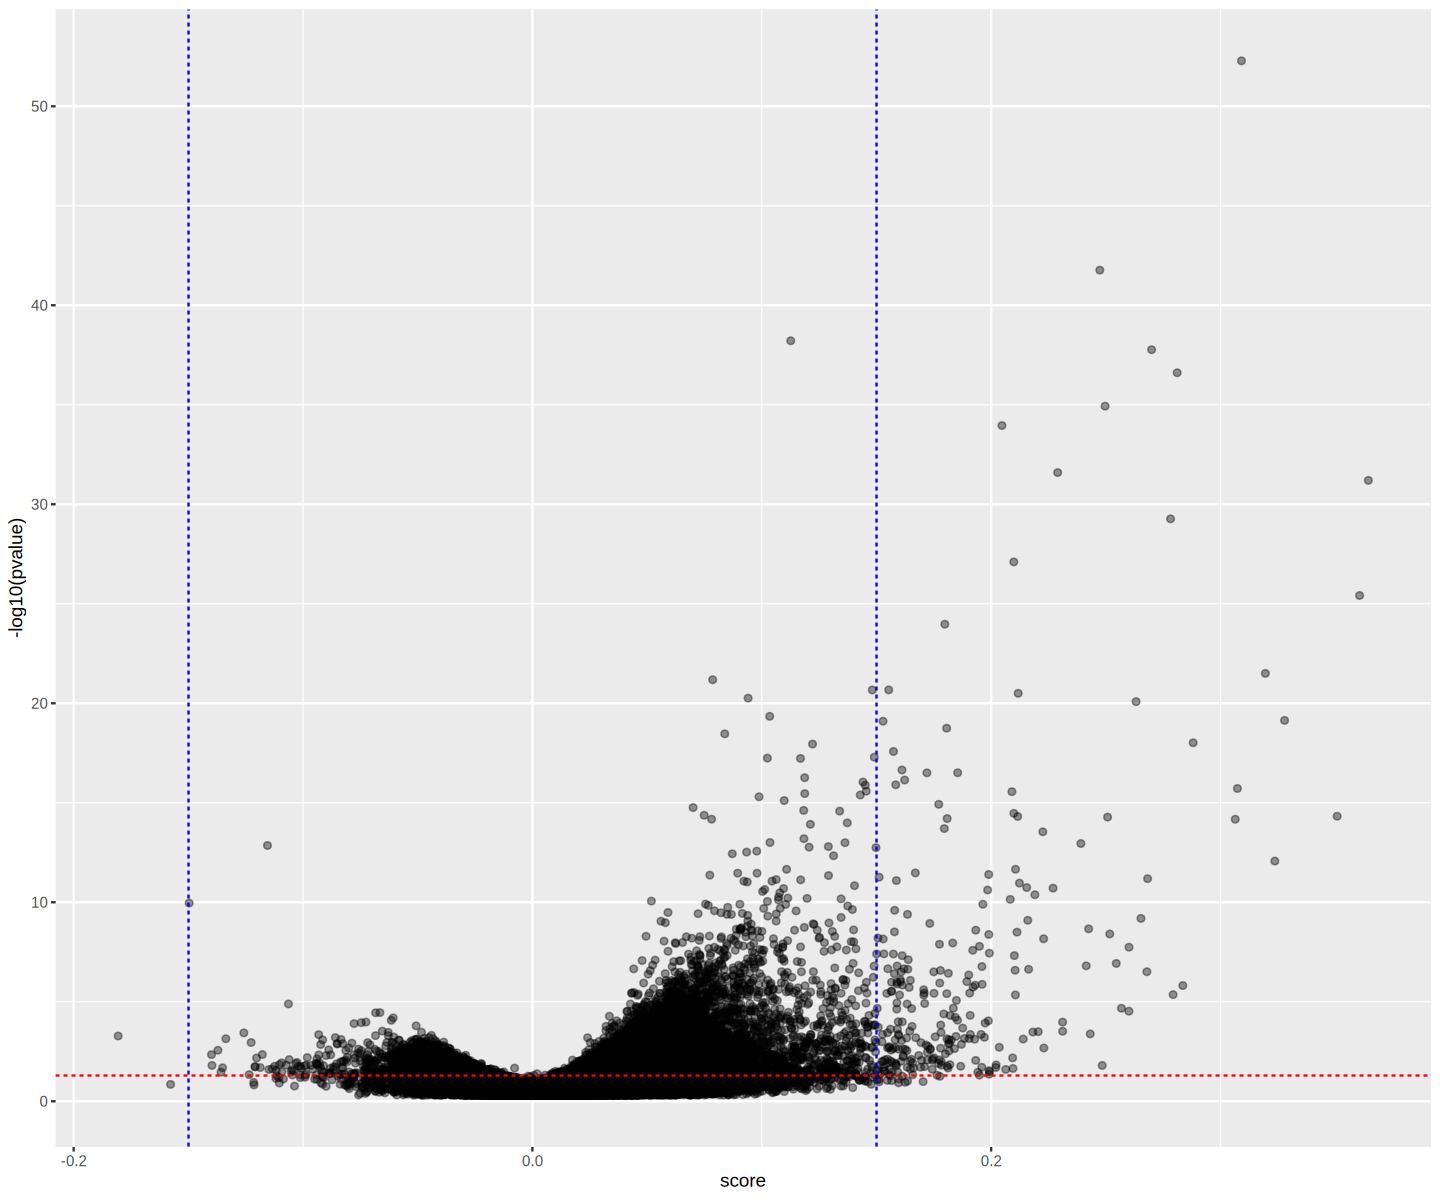

In [16]:
options(repr.plot.width = 12, repr.plot.height = 10)
ggplot(cd14_mono_p2g, aes(x = score, y = -log10(pvalue))) + 
    geom_point(alpha = 0.4) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red", linewidth = 0.5) +
    geom_vline(xintercept = 0.15, linetype = "dashed", color = "blue", linewidth = 0.5) +
    geom_vline(xintercept = -0.15, linetype = "dashed", color = "blue", linewidth = 0.5)

##### We can add annotation to the volcano plot to see the top hits.

Below, we annotated top 10 peak-gene links with the most significant p-value.


In [17]:
top_cd14_mono_p2g <- cd14_mono_p2g |> arrange(pvalue) |> head(10)
top_cd14_mono_p2g

,seqnames,start,end,width,strand,score,gene,peak,zscore,pvalue
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,chr13,41457412,41457550,139,*,0.3091402,RGCC,chr13-41456949-41457875,15.27986,5.207938e-53
2,chr1,58779981,58784047,4067,*,0.2473869,JUN,chr1-58779549-58780413,13.61131,1.715199e-42
3,chr10,8034137,8045378,11242,*,0.1126264,GATA3,chr10-8033792-8034481,13.00056,6.072188e-39
4,chr1,186670220,186680423,10204,*,0.2699668,PTGS2,chr1-186669809-186670630,12.92154,1.701269e-38
5,chr1,192575763,192580722,4960,*,0.2811103,RGS1,chr1-192580337-192581106,12.71425,2.464168e-37
6,chr1,186671250,186680423,9174,*,0.2496843,PTGS2,chr1-186670829-186671670,12.40852,1.174804e-35
7,chr4,20251868,20251905,38,*,0.2047134,SLIT2,chr4-20251473-20252262,12.22774,1.105009e-34
8,chr7,22725884,22732917,7034,*,0.2290082,IL6,chr7-22732466-22733367,11.77758,2.546718e-32
9,chr2,112831992,112836816,4825,*,0.3644556,IL1B,chr2-112831582-112832401,11.70081,6.311933e-32


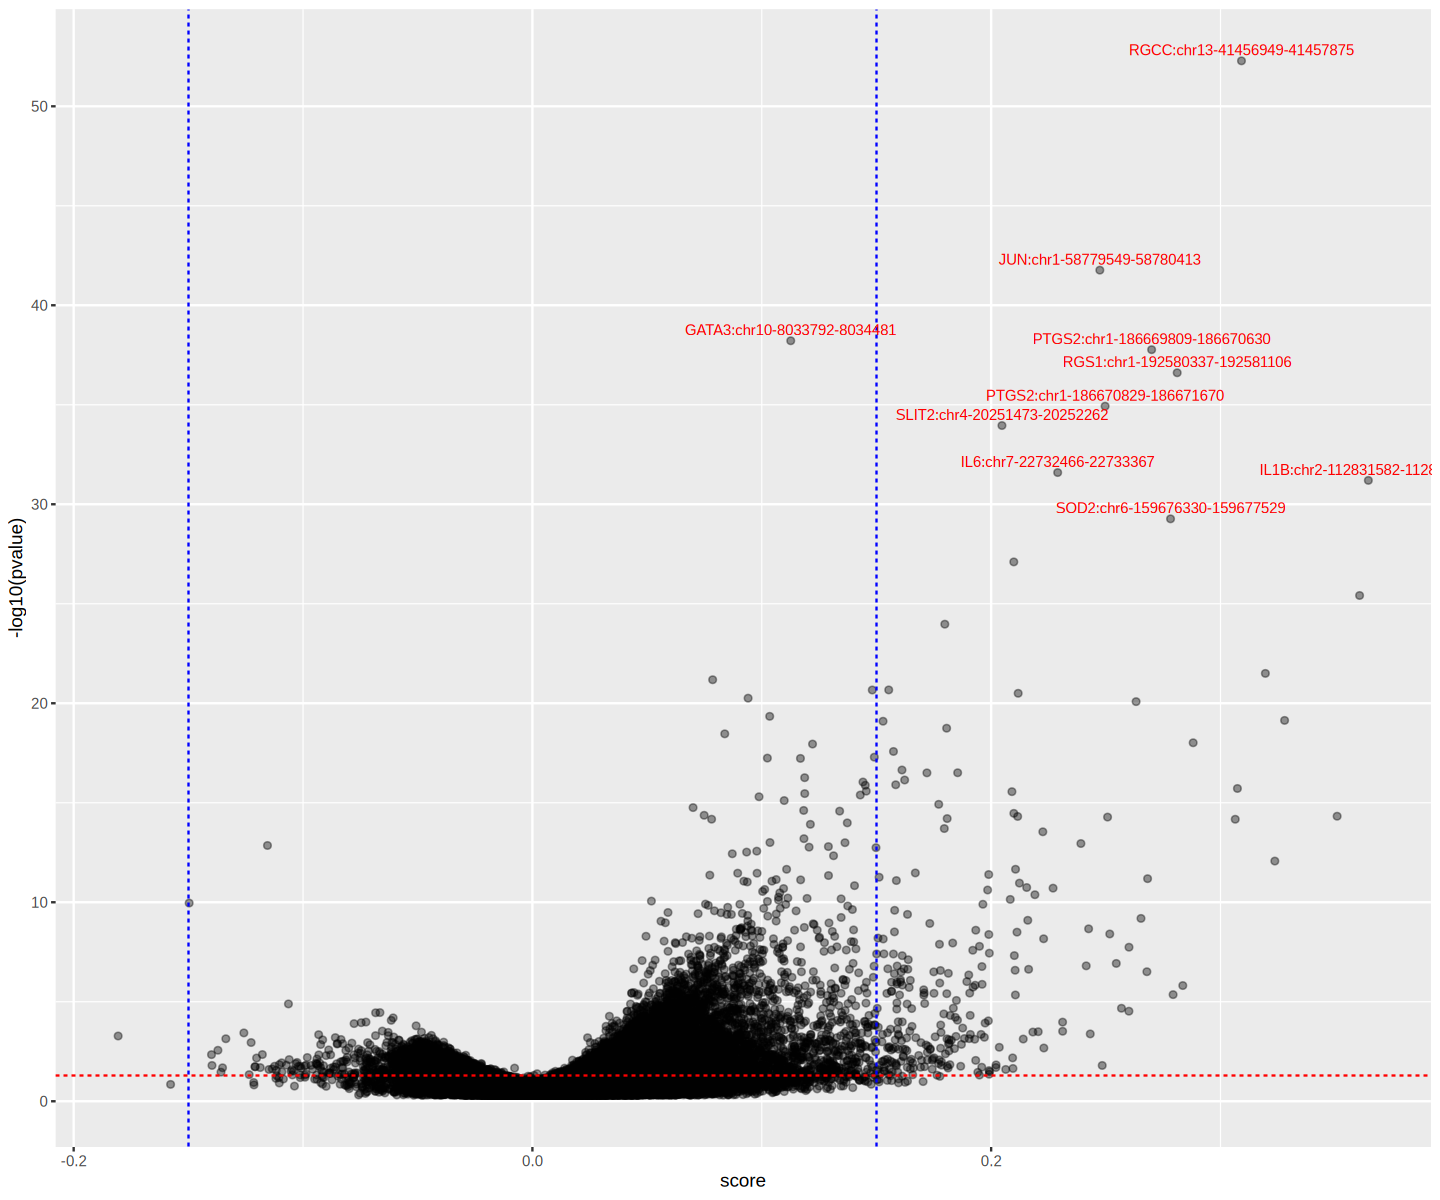

In [18]:

options(repr.plot.width = 12, repr.plot.height = 10)
ggplot(cd14_mono_p2g, aes(x = score, y = -log10(pvalue))) + 
    geom_point(alpha = 0.4) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red", linewidth = 0.5) +
    geom_vline(xintercept = 0.15, linetype = "dashed", color = "blue", linewidth = 0.5) +
    geom_vline(xintercept = -0.15, linetype = "dashed", color = "blue", linewidth = 0.5) +
    geom_text(data = top_cd14_mono_p2g, aes(label = paste0(gene, ":", peak)),
              vjust = -0.5, hjust = 0.5, size = 3, color = "red")



##### We can visualize the RNA-seq and ATAC-seq across cells for each cell type to see whether the correlation is correctly estimated.

Let's go back to one of the cell-type-specific open chromatin peak showing correlation with the `LYZ` gene.

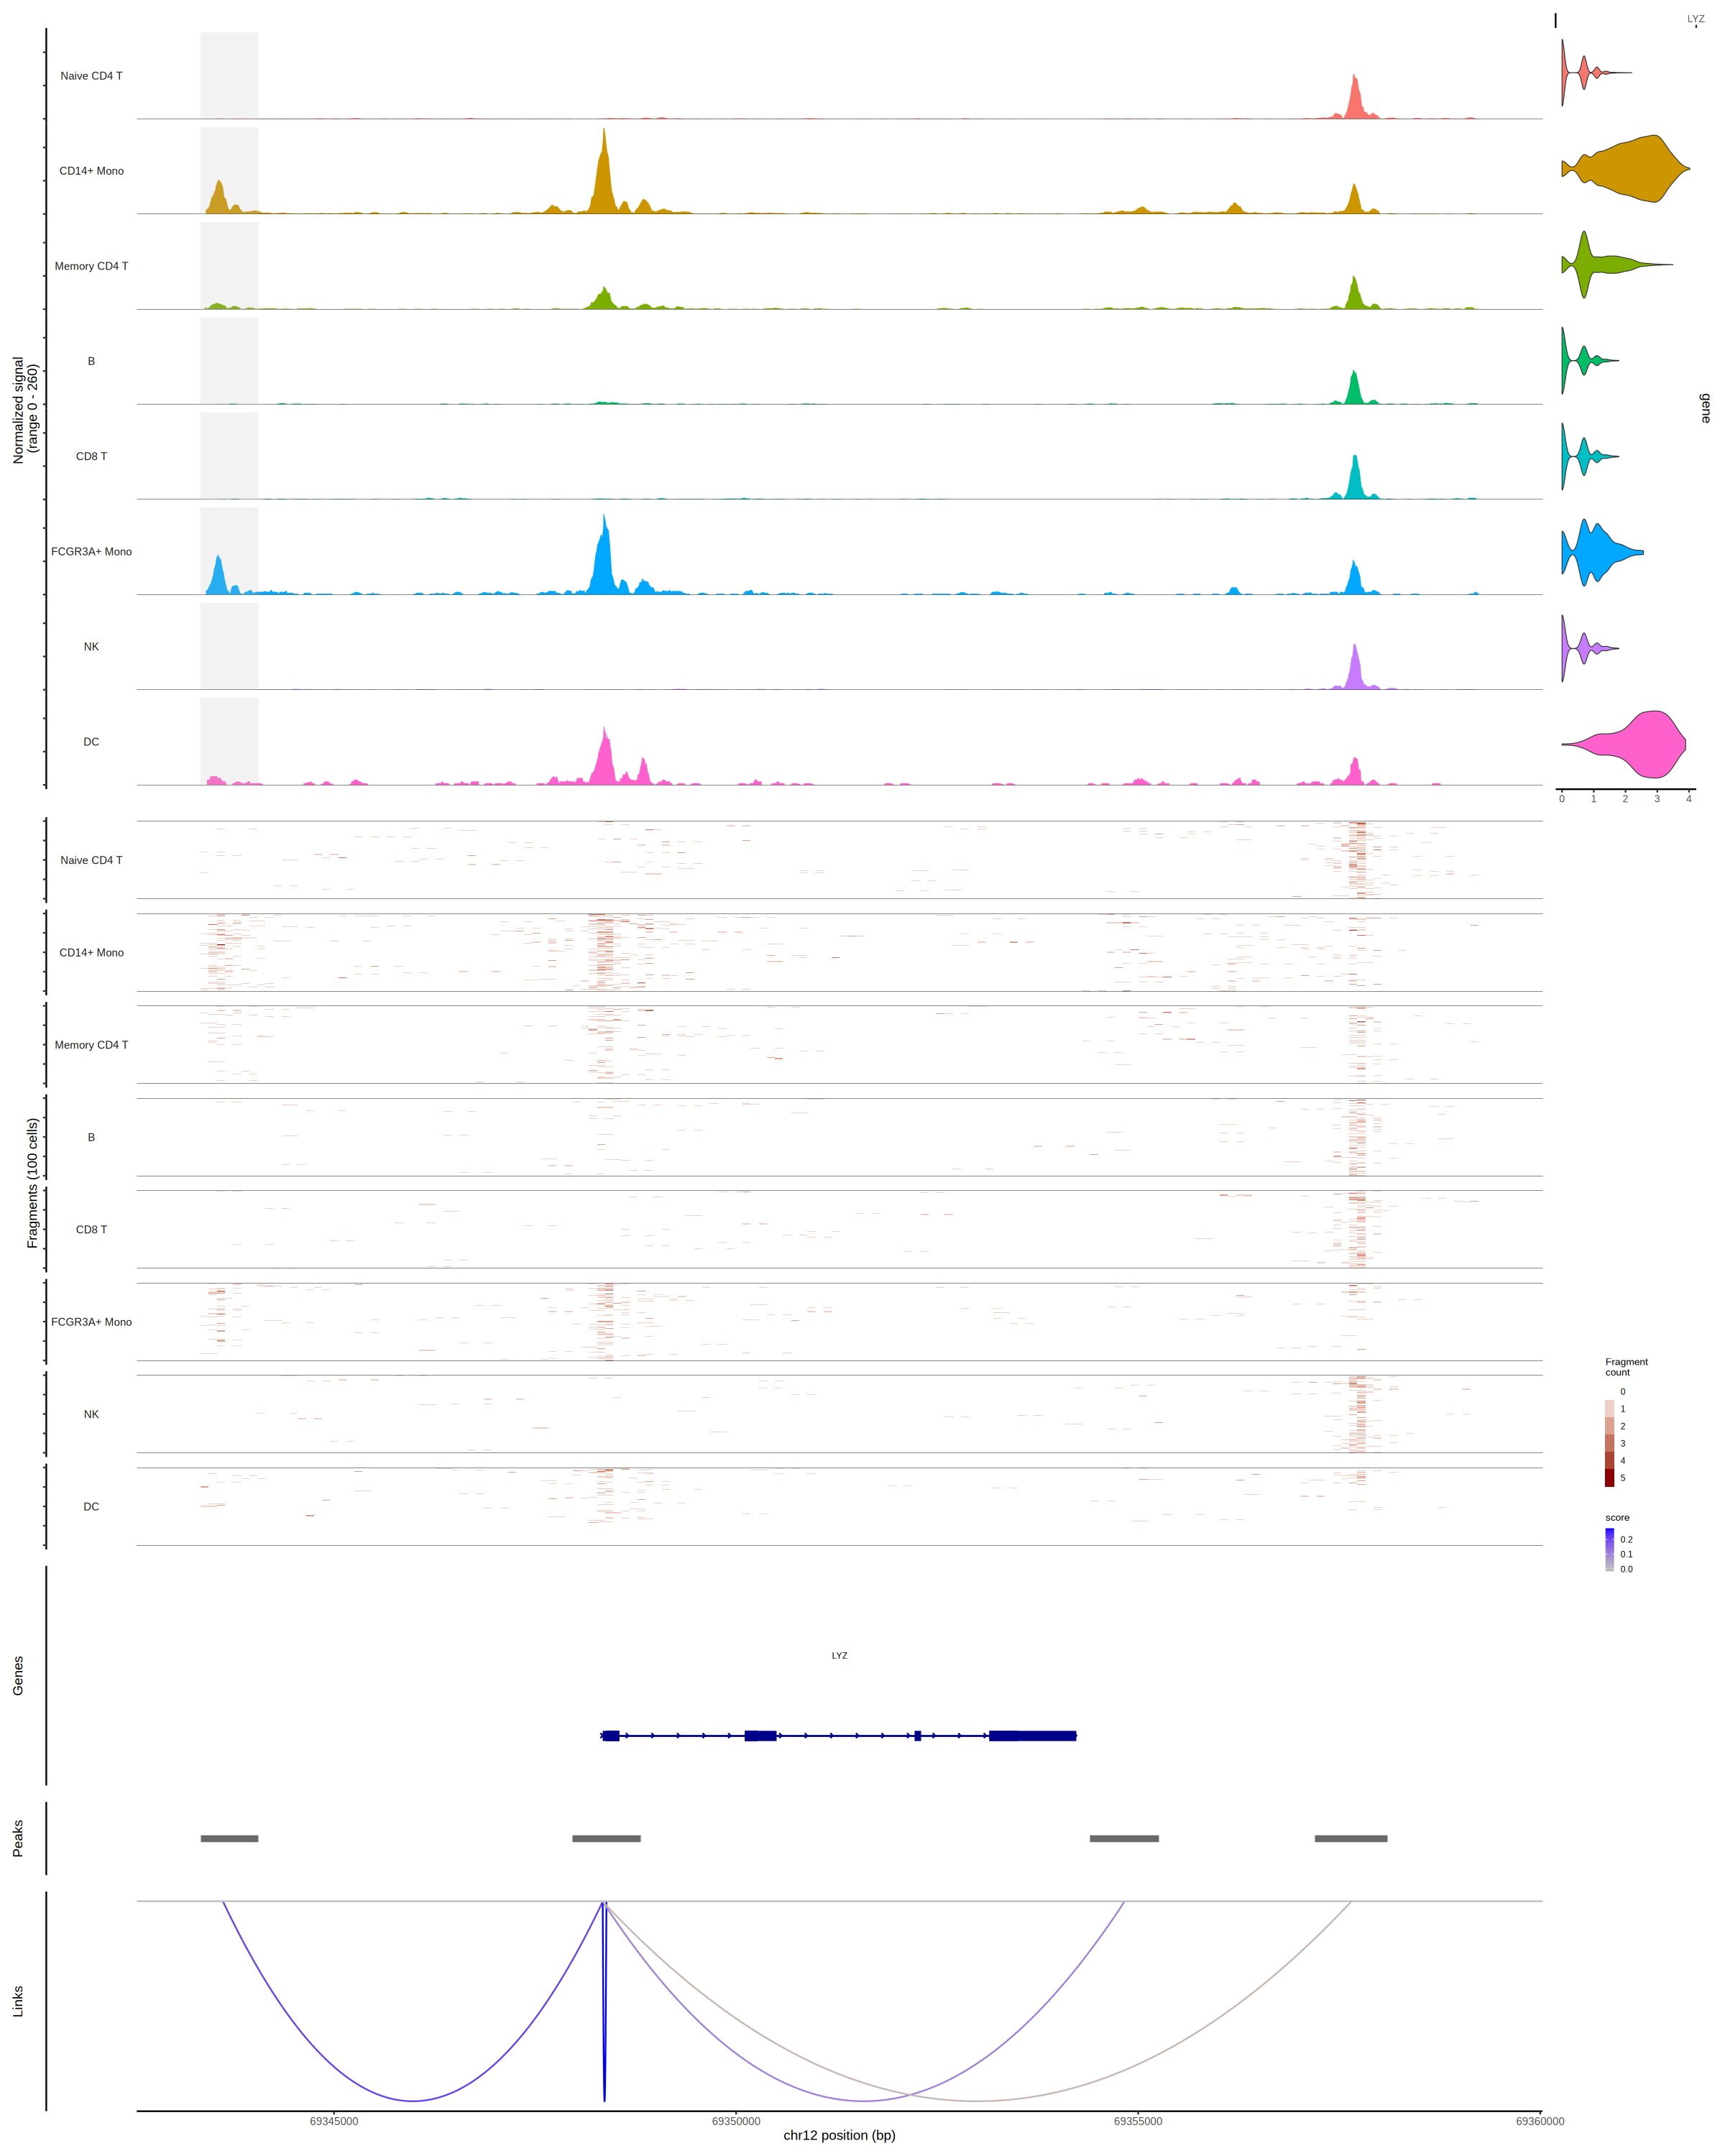

In [19]:

# Example list of peaks
peak_list <- c("chr12-69343181-69344057")

# Split and convert
peak_parts <- do.call(rbind, strsplit(peak_list, "-"))
gr_peak <- GRanges(
  seqnames = peak_parts[,1],
  ranges = IRanges(start = as.numeric(peak_parts[,2]),
                   end   = as.numeric(peak_parts[,3]))
)



options(repr.plot.width = 20, repr.plot.height = 25)

CoveragePlot(
    object = multi_merged,
    region = "LYZ",
    extend.upstream = 5000,
    extend.downstream = 5000,
    features = c("LYZ"),
    expression.assay = "SCT",
    annotation = TRUE,
    peaks = TRUE,
    links = TRUE,
    tile = TRUE,
    region.highlight = gr_peak
) #& theme(text = element_text(size = 20))




In [22]:


# plot RNA-ATAC concordance for each cell type
celltype_p2g_heatmap <- function(object, gene, peak, celltype_col, 
                             gene.assay = "RNA", gene.layer = "data",
                             peak.assay = "ATAC", peak.layer = "counts",
                             binarize = TRUE, orientation = "vertical", 
                             remove_zero = FALSE, sort_by = "rna",
                             verbose = FALSE
                            ) {
    if (!(gene %in% rownames(object[[gene.assay]]))) {
        stop(paste0(gene, " not found in ", gene.assay, " assay\n"))
    }
    if (!(peak %in% rownames(object[[peak.assay]]))) {
        stop(paste0(peak, " not found in ", peak.assay, " assay\n"))
    }
    if (!(celltype_col %in% colnames(object@meta.data))) {
        stop(paste0(celltype_col, " column not found in metadata\n"))
    }
    if (!(gene.assay %in% Assays(object))) {
        stop(paste0(gene.assay, " assay not found\n"))
    }
    if (!(peak.assay %in% Assays(object))) {
        stop(paste0(peak.assay, " assay not found\n"))
    }
    
    temp_df <- data.frame(rna = GetAssayData(object, assay = gene.assay, layer = gene.layer)[gene, ],
                          atac = GetAssayData(object, assay = peak.assay, layer = peak.layer)[peak, ],
                          celltype = object@meta.data[[celltype_col]])
    # max_rna_value <- max(temp_df$rna)

    if (verbose) {
        print(temp_df |> 
              group_by(celltype) |>
              summarise(
                  cell = n(),
                  rna_expr = sum(rna > 0),
                  atac_expr = sum(atac > 0),
                  rna_atac = sum((rna > 0) & (atac > 0)),
                  .groups = "drop"
              )
        )
    }
    
    if (binarize) {
        temp_df$atac <- ifelse(temp_df$atac > 0, 1, 0)
    }

    if (remove_zero) {
        temp_df <- temp_df |> filter(rna > 0)
    }

    # Rank genes by RNA descending per celltype
    if (sort_by == "rna") {
        temp_df_sorted <- temp_df %>% 
                group_by(celltype) %>%
                arrange(
                        desc(rna),
                        .by_group = TRUE) %>%
                mutate(row = row_number()) %>%
                ungroup()
    } else if (sort_by == "atac") {
        temp_df_sorted <- temp_df %>% 
                group_by(celltype) %>%
                arrange(
                        desc(atac), desc(rna),
                        .by_group = TRUE) %>%
                mutate(row = row_number()) %>%
                ungroup()
    } else {
        stop(paste0("Cannot sort by ", sort_by, " \n"))
    }
    
    # Prepare separate data frames for RNA and ATAC
    rna_df <- temp_df_sorted %>%
            select(celltype, row, value = rna) %>%
            mutate(type = "RNA")
    
    atac_df <- temp_df_sorted %>%
            select(celltype, row, value = atac) %>%
            mutate(type = "ATAC")

    # Combine for plotting
    plot_df <- bind_rows(rna_df, atac_df)


    if (orientation == "horizontal") {
        p <- ggplot() +
        
        # RNA > 0 layer with viridis
        geom_tile(
            data = filter(plot_df, type == "RNA" & value > 0),
            aes(x = type, y = row, fill = value)
        ) +
        scale_fill_viridis_c(name = "RNA Expression") +

        # RNA = 0 layer in gray
        geom_tile(
            data = filter(plot_df, type == "RNA" & value == 0),
            aes(x = type, y = row),
            fill = "gray90"
        ) +
        
        # Add a new fill scale for ATAC
        ggnewscale::new_scale_fill() +
        geom_tile(data = filter(plot_df, type == "ATAC"),
                aes(x = type, y = row, fill = value)) +
        scale_y_reverse() +
        facet_wrap(~celltype, scales = "free_x", nrow = 1) +
        labs(x = NULL, y = "Cell Rank by RNA expression")

    } else if (orientation == "vertical") {
        p <- ggplot() +
        
        # RNA > 0 layer with viridis
        geom_tile(
            data = filter(plot_df, type == "RNA" & value > 0),
            aes(y = type, x = row, fill = value)
        ) +
        scale_fill_viridis_c(name = "RNA Expression") +

        # RNA = 0 layer in gray
        geom_tile(
            data = filter(plot_df, type == "RNA" & value == 0),
            aes(y = type, x = row),
            fill = "gray90"
        ) +
        
        # New fill scale for ATAC
        ggnewscale::new_scale_fill() +
        geom_tile(data = filter(plot_df, type == "ATAC"),
            aes(y = type, x = row, fill = value), height = 0.9) +
        facet_wrap(~celltype, scales = "free_y", ncol = 1) +
        labs(x = "Cell Rank by RNA expression", y = NULL)
        
    }

    if (binarize) {
        p <- p + scale_fill_gradient(name = "ATAC Signal", 
                                     low = "#ffe5e5", high = "salmon",
                                     breaks = c(0, 1), labels = c("0", "1")
                                    )
    } else {
        p <- p + scale_fill_distiller(name = "ATAC Signal", palette = "Reds", direction = 1)
    }
    
    p <- p + 
    plot_annotation(title = paste0("\n", gene, " vs. ", peak, "\n"),
                                    theme = theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))
                                  ) +
    theme_classic() +
    theme(
        strip.text = element_text(face = "bold", size = 9),
        axis.title.y = element_text(size = 7, face = "bold"), axis.text.y = element_text(size = 6),
        axis.title.x = element_text(size = 7, face = "bold"), axis.text.x = element_text(size = 6),
        legend.title = element_text(size = 9), legend.text = element_text(size = 7),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank()
    ) 
    
    return (p)
}



# A tibble: 8 × 5
  celltype      cell rna_expr atac_expr rna_atac
  <fct>        <int>    <int>     <int>    <int>
1 Naive CD4 T   6085     2584        18       10
2 CD14+ Mono    3997     3839       339      332
3 Memory CD4 T  1860     1659        30       23
4 B             1240      482         2        2
5 CD8 T         1511      679         2        0
6 FCGR3A+ Mono   466      379        41       36
7 NK            1866      778         1        0
8 DC             189      188         8        8


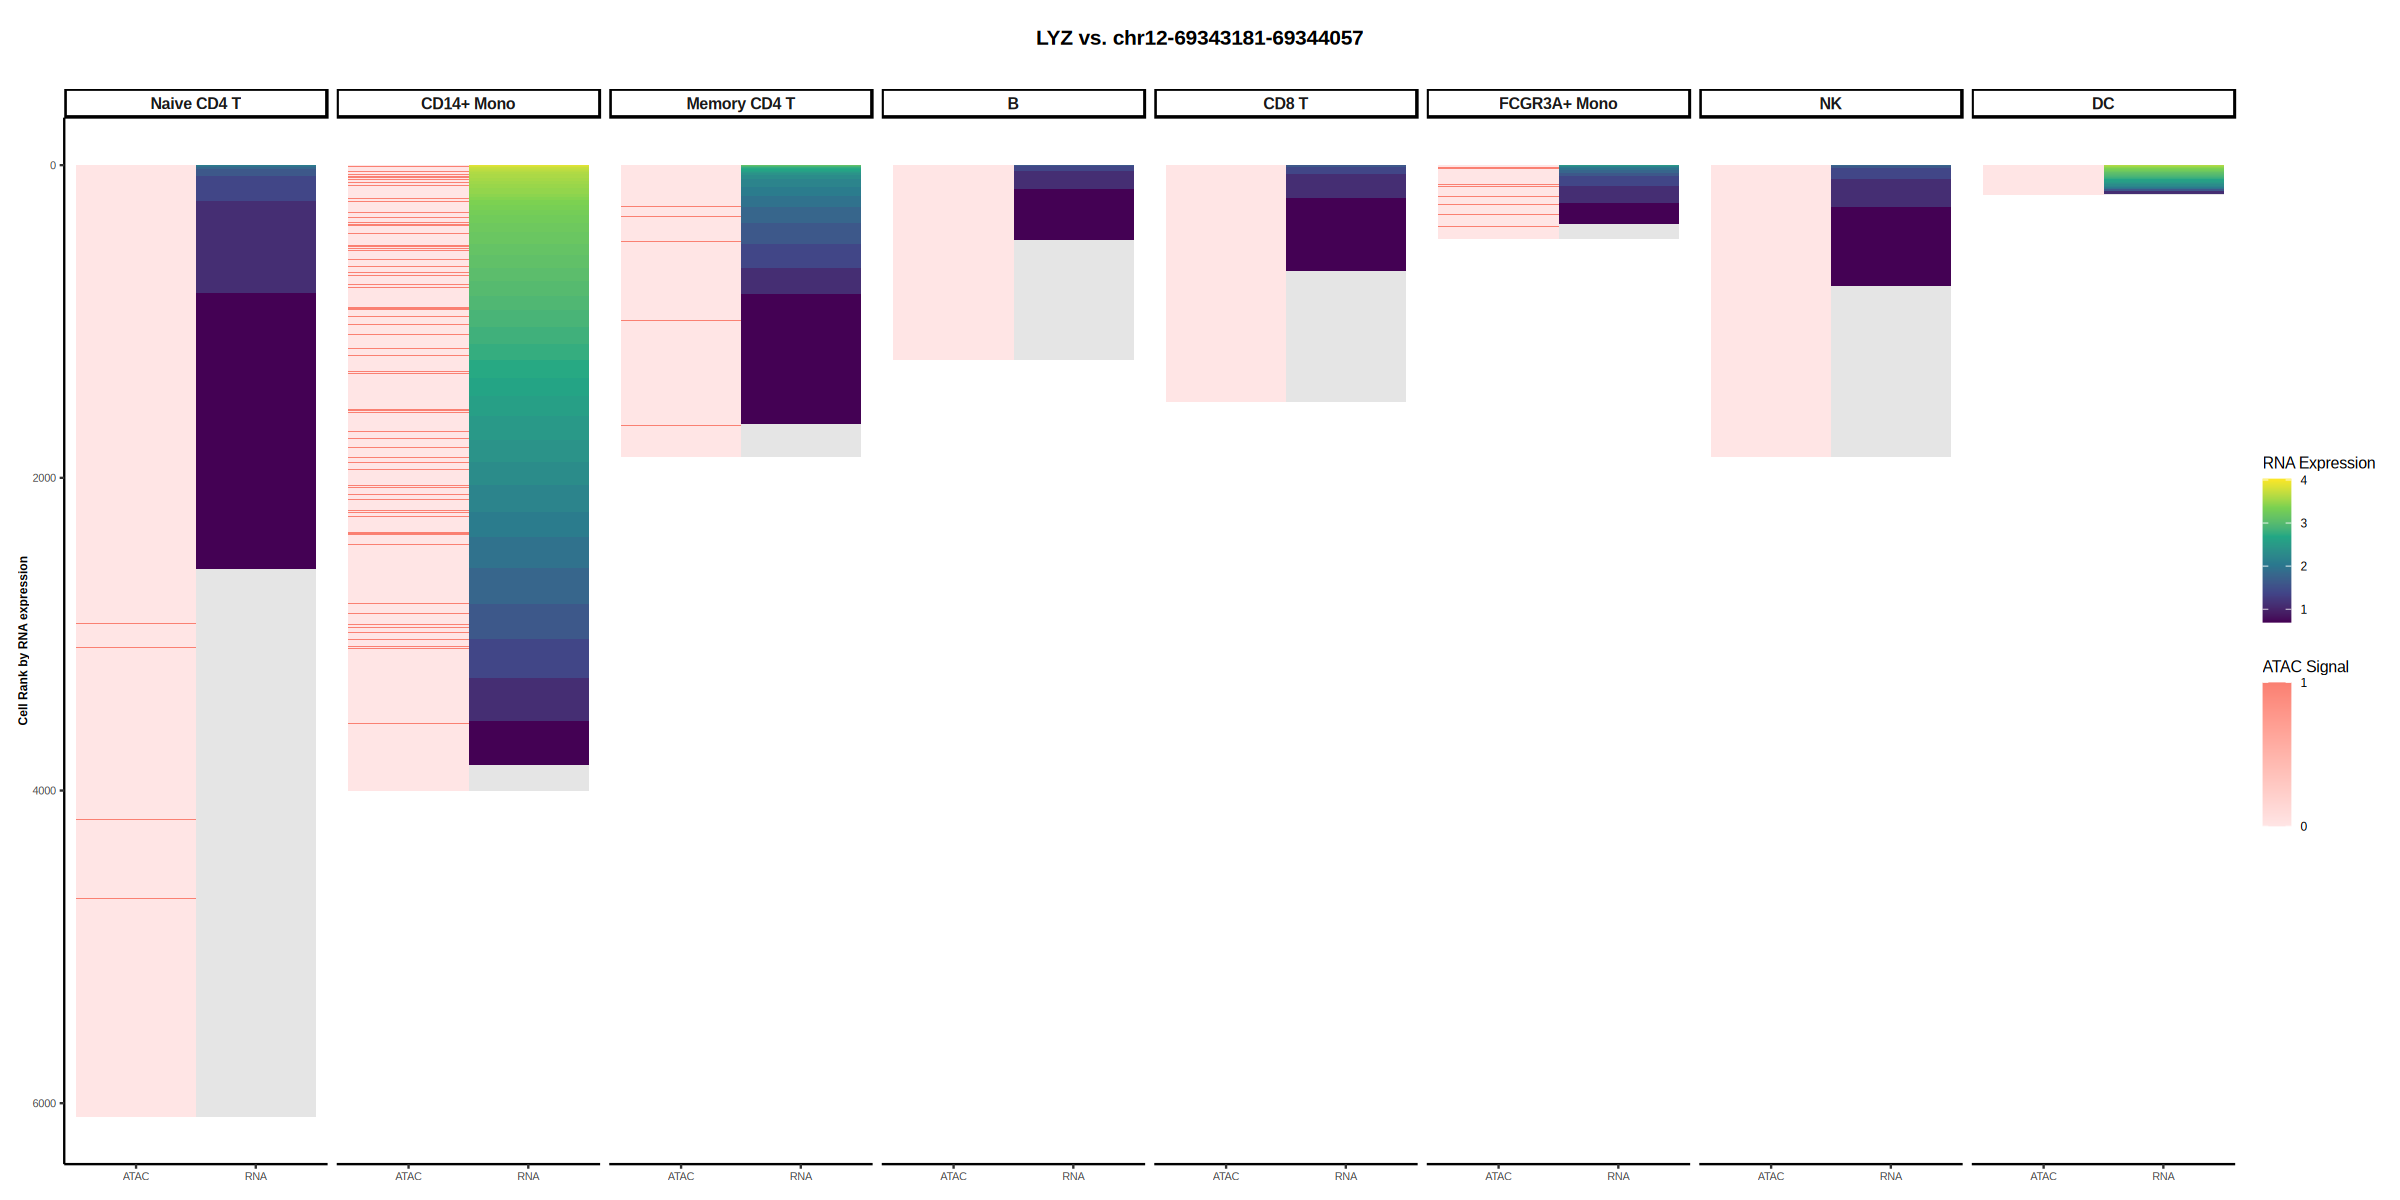

In [24]:

options(repr.plot.width = 20, repr.plot.height = 10)
celltype_p2g_heatmap(multi_merged, 
                     gene = "LYZ", 
                     peak = "chr12-69343181-69344057",
                     celltype_col = "annot_cell_type",
                     gene.assay = "SCT", gene.layer = "data",
                     peak.assay = "ATAC", peak.layer = "counts",
                     binarize = TRUE, orientation = "horizontal", 
                     remove_zero = FALSE, sort_by = "rna",
                     verbose = TRUE
                    )



In [20]:


celltype_p2g_barplot <- function(object, gene, peak, celltype_col, 
                                 gene.assay = "RNA", gene.layer = "data",
                                 peak.assay = "ATAC", peak.layer = "counts",
                                 n_bin = 10, 
                                 remove_zero = FALSE,
                                 celltypes = c(),
                                 verbose = FALSE
                                ) {
    if (!(gene %in% rownames(object[[gene.assay]]))) {
        stop(paste0(gene, " not found in ", gene.assay, " assay\n"))
    }
    if (!(peak %in% rownames(object[[peak.assay]]))) {
        stop(paste0(peak, " not found in ", peak.assay, " assay\n"))
    }
    if (!(celltype_col %in% colnames(object@meta.data))) {
        stop(paste0(celltype_col, " column not found in metadata\n"))
    }
    if (!(gene.assay %in% Assays(object))) {
        stop(paste0(gene.assay, " assay not found\n"))
    }
    if (!(peak.assay %in% Assays(object))) {
        stop(paste0(peak.assay, " assay not found\n"))
    }

    df <- data.frame(rna = GetAssayData(object, assay = gene.assay, layer = gene.layer)[gene, ],
                          atac = GetAssayData(object, assay = peak.assay, layer = peak.layer)[peak, ],
                          celltype = object@meta.data[[celltype_col]])

    if (length(celltypes) > 0) {
        df <- df |> filter(celltype %in% celltypes)
    }
    
    df$cell <- rownames(df)
    df$sample <- sapply(strsplit(df$cell, ":"), `[`, 1)
    df <- df |> mutate(rna_group = ifelse(rna > 0, TRUE, FALSE))

    
    # Bin RNA values

    no_rna_df <- df |> filter(rna == 0) |> mutate(rna_bin = 0)
    rna_df <- df |> 
        filter(rna > 0) |> 
        arrange(rna) |> 
        group_by(celltype) |> 
        mutate(rna_bin = ntile(row_number(), n_bin)) |>
        ungroup()
    if (remove_zero) {
        df <- rna_df
    } else {
        df <- rbind(no_rna_df, rna_df)
    }
    bin_labels <- c("FALSE_0", paste0("TRUE_", c(1:n_bin)))
    df <- df |> mutate(bin = paste0(rna_group, "_", rna_bin))
    
    # Calculate fraction of open peaks for each bin and cell type
    summary_df <- df |>
        group_by(celltype, bin, rna_group) |>
        summarise(
        total = n(),
        atac_1 = sum(atac > 0),
        fraction = atac_1 / total,
        .groups = "drop"
    )

    
    summary_df$bin <- factor(summary_df$bin, levels = bin_labels)
    
    max_fraction <- max(summary_df$fraction)
    y_pos_df <- summary_df |>
      group_by(celltype) |>
      summarise(y = 0.01 + max_fraction, .groups = "drop")  # slightly above max
    
    # Plot faceted barplot of fraction of open chromatins
    barplot <- ggplot(summary_df, aes(x = bin, y = fraction)) +
        geom_bar(stat = "identity", aes(fill = rna_group)) +
        facet_wrap(~celltype, nrow = 1) +
        labs(x = "Gene expression bin", 
             y = "Fraction of cells with open chromatin",
             fill = "RNA detected"
            )
    
    final_plot <-   barplot +
                    plot_annotation(title = paste0("\n", gene, " vs. ", peak, "\n"),
                                    theme = theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))
                                   ) +
        theme_classic() +
        theme(
            strip.text = element_text(face = "bold", size = 9),
            axis.title.y = element_text(size = 10, face = "bold"), axis.text.y = element_text(size = 9),
            axis.title.x = element_text(size = 10, face = "bold"), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            legend.title = element_text(size = 9), legend.text = element_text(size = 8),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()
        )
    return(final_plot)

}



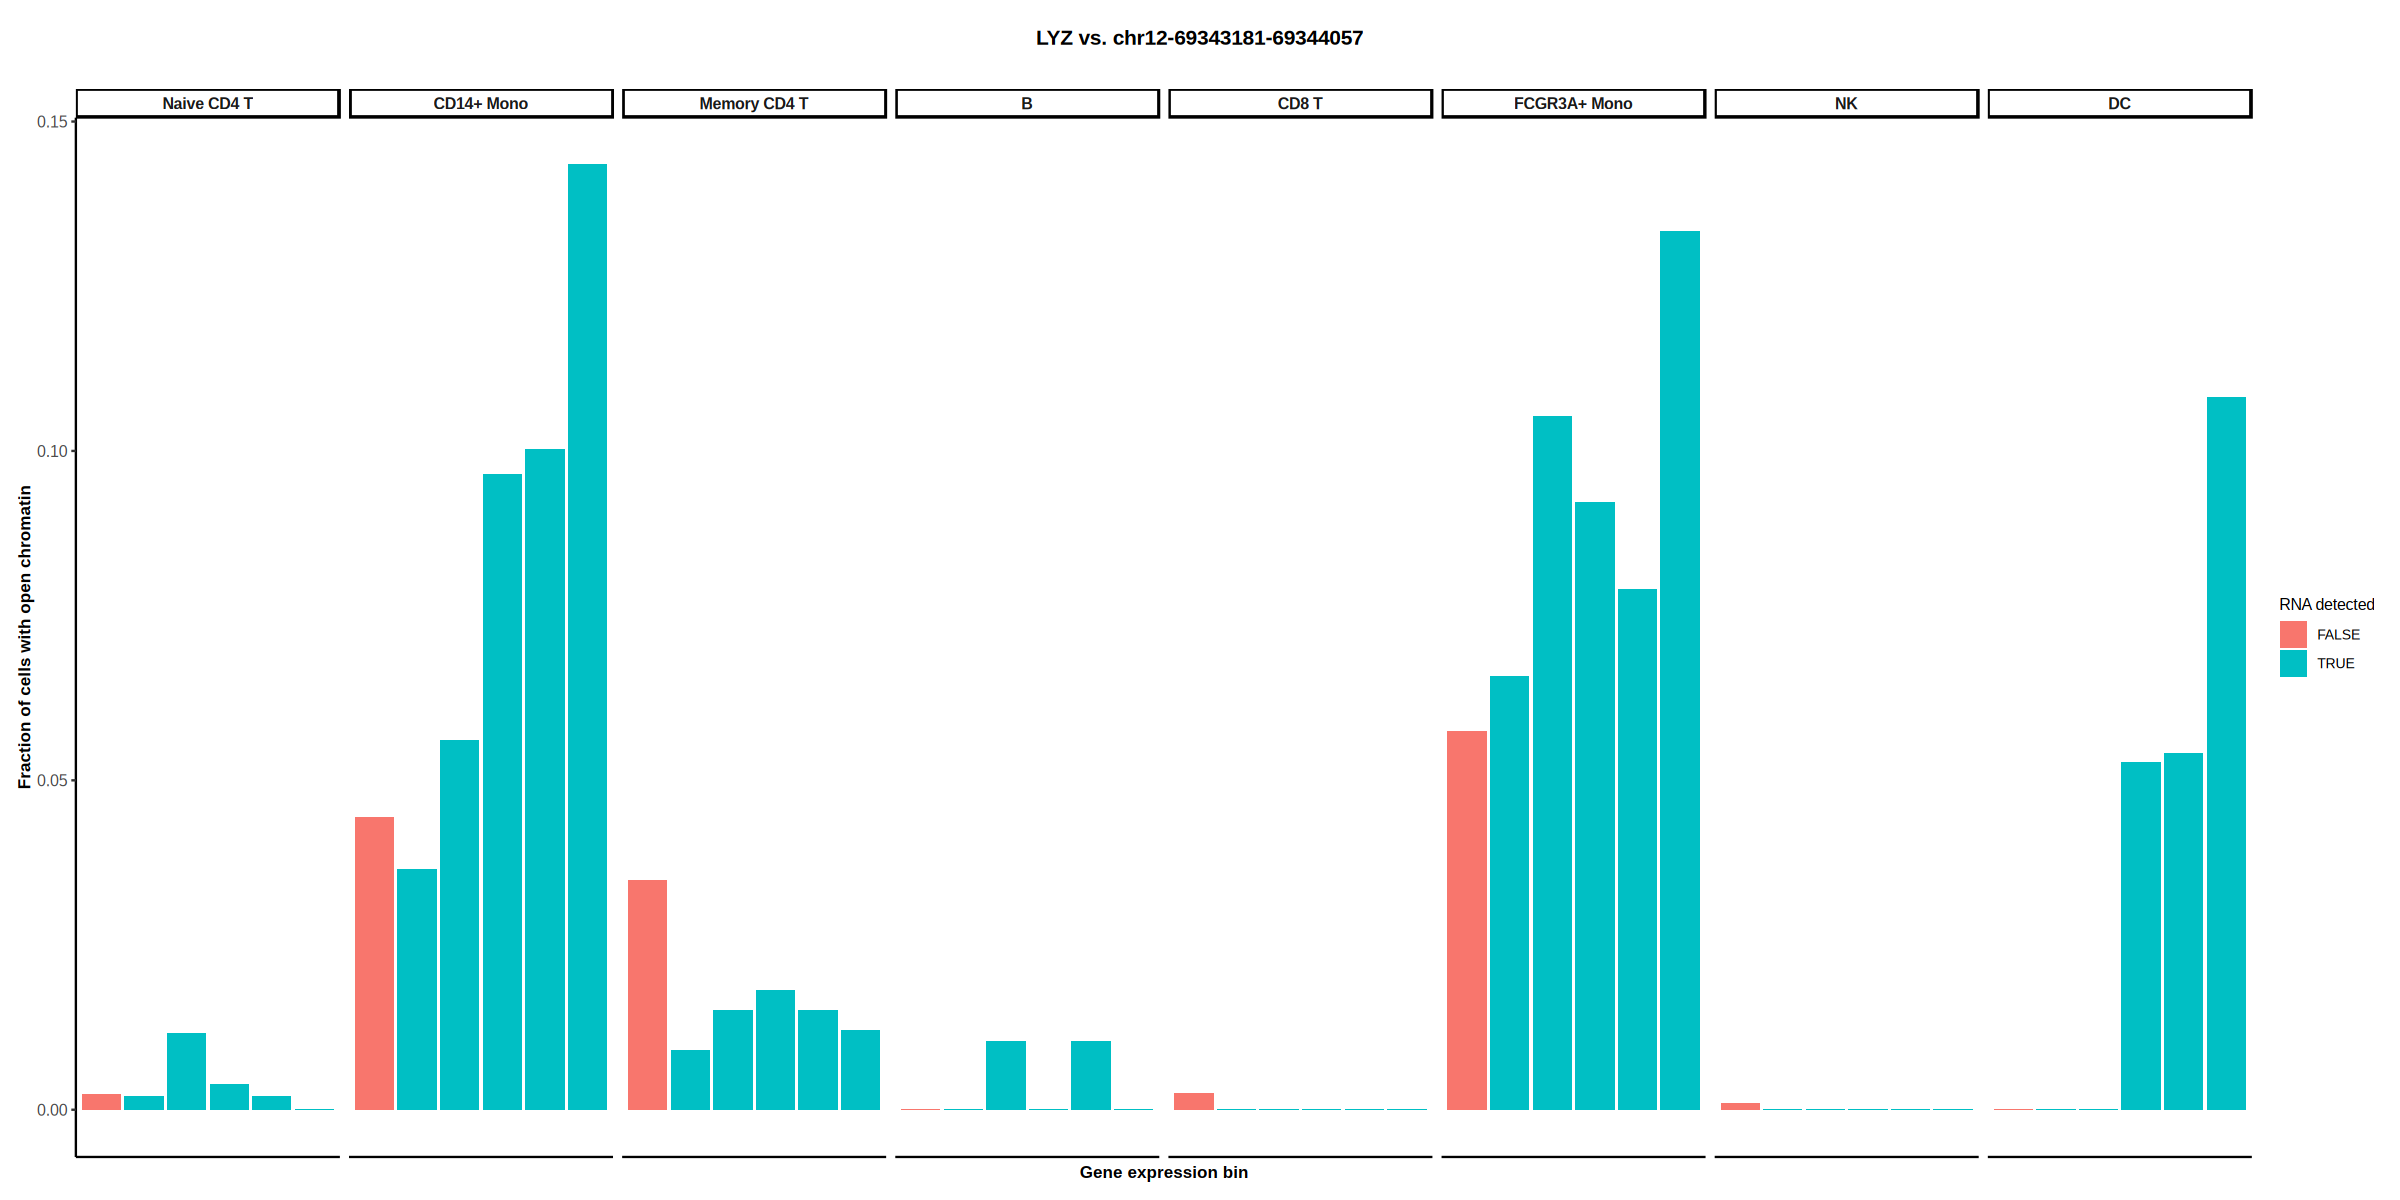

In [21]:

options(repr.plot.width = 20, repr.plot.height = 10)
celltype_p2g_barplot(multi_merged, 
                     gene = "LYZ", 
                     peak = "chr12-69343181-69344057",
                     celltype_col = "annot_cell_type",
                     gene.assay = "SCT", gene.layer = "data",
                     peak.assay = "ATAC", peak.layer = "counts",
                     n_bin = 5, 
                     remove_zero = FALSE,
                     celltypes = c(),
                     verbose = TRUE
                    )



In [25]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.10 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /home/ch260976/.conda/envs/jlab/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] viridisLite_0.4.2                 ggnewscale_0.5.1                 
 [3] patchwork_1.3.0                   ggforce_0.4.2                    
 [5] ggplot2_3.5.1                     dplyr_1.1.4